# Coursework: Age regression from brain MRI

Predicting the age of a patient from their brain MRI scan can have diagnostic value for a number of diseases that may cause structural changes and potential damage to the brain. A discrepancy between the predicted age and the real, chronological age of a patient might indicate the presence of disease. This requires an accurate predictor of brain age which may be learned from a set of healthy reference subjects, given their brain MRI data and their actual age.

**The objective for the coursework is to implement two supervised learning approaches for age regression from brain MRI.** We provide data from a total of 652 healthy subjects, split into different development sets and a hold-out test set on which you will evaluate your final prediction accuracy.

Each approach will require a processing pipeline with different components that you will need to implement using methods that were discussed in the lectures and tutorials. There are two dedicated parts in the Jupyter notebook for each approach which contain some detailed instructions and some helper code.

You may find some useful ideas and implementations in the tutorial notebooks. Once you have implemented both approaches and obtained results from your experiments, we ask you to write a short summary report. The reports should contain a short introduction, description of each of your methods and the individual processing steps, your results with a brief discussion. The report should also include some figures and plots to support your findings and illustrate your results.

#### Read the text descriptions and code cells carefully and look out for the cells marked with 'TASK' and 'ADD YOUR CODE HERE'.

## Part B: Age prediction using regression CNNs

For the second approach we will use a convolutional neural network to directly predict a subject's age.

You will need to implement a CNN model that takes an MRI scan as an input and maps it to a one-dimensional, real-valued output. A good starting point may be a LeNet-type architecture and adapt the last layers to convert the classification into a regression network. You should have all the necessary ingredients now from previous tasks and the notebooks from the lab tutorials for how to set up a CNN model in PyTorch, how to implement a suitable training and testing routine, and how to run a two-fold cross-validation on the 500 subjects similar to task A. For the final age prediction model, you should use all 500 subjects for training and you may want to use the 47 subjects that we used for training the tissue segmentation model as your validation data.

*Note:* Similar to task A, you may want to set up a pre-processing pipeline that involves intensity normalisation and resampling of the input data.

### Imports

In [1]:
! pip install SimpleITK 
! wget https://www.doc.ic.ac.uk/~bglocker/teaching/mli/brainage-data.zip
! unzip brainage-data.zip

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torchvision.transforms import CenterCrop
import pandas as pd
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# data directory
data_dir = 'data/brain_age/'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 26.2 MB/s eta 0:00:00
--2023-03-02 16:32:28--  https://www.doc.ic.ac.uk/~bglocker/teaching/mli/brainage-data.zip
Resolving www.doc.ic.ac.uk (www.doc.ic.ac.uk)... 146.169.13.6
Connecting to www.doc.ic.ac.uk (www.doc.ic.ac.uk)|146.169.13.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 468654948 (447M) [application/zip]
Saving to: ‘brainage-data.zip’

brainage-data.zip   100%[===================>] 446.94M   262MB/s    in 1.7s    

2023-03-02 16:32:30 (262 MB/s) - ‘brainage-data.zip’ saved [468654948/468654948]

Archive:  brainage-data.zip
   creating: data/
   creating: data/brain_age/
   creating: data/brain_age/images/
  inflating: data/brain_age/images/sub-CC110033_T1w_unbiased.nii.gz  
  inflating: data/brain_age/images/sub-CC110037_T1w_unbiased.nii.gz  
  inflating: data/brain_age/images/sub-CC110045_

### Helper Functions From Previous Section (For re-running purposes)

In [2]:
def zero_mean_unit_var(image, mask):
    """Normalizes an image to zero mean and unit variance."""

    img_array = sitk.GetArrayFromImage(image)
    img_array = img_array.astype(np.float32)

    msk_array = sitk.GetArrayFromImage(mask)

    mean = np.mean(img_array[msk_array>0])
    std = np.std(img_array[msk_array>0])
    if std > 0:
        img_array = (img_array - mean) / std
        img_array[msk_array==0] = 0

    image_normalised = sitk.GetImageFromArray(img_array)
    image_normalised.CopyInformation(image)

    return image_normalised

def resample_image(image, out_spacing=(1.0, 1.0, 1.0), out_size=None, is_label=False, pad_value=0):
  """Resamples an image to given element spacing and output size."""

  original_spacing = np.array(image.GetSpacing())
  original_size = np.array(image.GetSize())

  if out_size is None:
      out_size = np.round(np.array(original_size * original_spacing / np.array(out_spacing))).astype(int)
  else:
      out_size = np.array(out_size)

  original_direction = np.array(image.GetDirection()).reshape(len(original_spacing),-1)
  original_center = (np.array(original_size, dtype=float) - 1.0) / 2.0 * original_spacing
  out_center = (np.array(out_size, dtype=float) - 1.0) / 2.0 * np.array(out_spacing)

  original_center = np.matmul(original_direction, original_center)
  out_center = np.matmul(original_direction, out_center)
  out_origin = np.array(image.GetOrigin()) + (original_center - out_center)

  resample = sitk.ResampleImageFilter()
  resample.SetOutputSpacing(out_spacing)
  resample.SetSize(out_size.tolist())
  resample.SetOutputDirection(image.GetDirection())
  resample.SetOutputOrigin(out_origin.tolist())
  resample.SetTransform(sitk.Transform())
  resample.SetDefaultPixelValue(pad_value)

  if is_label:
      resample.SetInterpolator(sitk.sitkNearestNeighbor)
  else:
      resample.SetInterpolator(sitk.sitkBSpline)

  return resample.Execute(image)

### Data Helpers


In [3]:
def split_into_k_folds(img_arr, msk_arr, age_arr, k=2):
  """
  Splits the given array into k folds.
  """

  if len(img_arr) != len(age_arr) or len(img_arr) != len(msk_arr):
    raise ValueError("Arrays must be of equal length")
  if k < 2:
      raise ValueError("k must be greater than 1")
  if k > len(img_arr):
      raise ValueError("k must be less than or equal to the length of the arrays")

  fold_size = len(img_arr) // k
  fold1 = []
  fold2 = []
  fold3 = []

  for i in range(0, len(img_arr), fold_size):
    fold1.append(img_arr[i:i+fold_size])
    fold2.append(msk_arr[i:i+fold_size])
    fold3.append(age_arr[i:i+fold_size])

  return fold1, fold2, fold3

# Define the ImageRegressionDataset(Dataset):
class ImageRegressionDataset(Dataset):
    """Dataset for image regression."""

    def __init__(self, file_list_img, file_list_msk, list_age, img_spacing, img_size):
        self.samples = []
        self.img_names = []
        self.ages = []
        for idx, _ in enumerate(tqdm(range(len(file_list_img)), desc='Loading Data')):
            img = sitk.ReadImage(file_list_img[idx], sitk.sitkFloat32)

            msk = sitk.ReadImage(file_list_msk[idx], sitk.sitkUInt8)

            #pre=processing
            img = zero_mean_unit_var(img, msk)
            img = resample_image(img, img_spacing, img_size, is_label=False)
            age = list_age[idx]

            sample = {'img': img, 'age': age}

            self.samples.append(sample)
            self.img_names.append(os.path.basename(file_list_img[idx]))
            self.ages.append(age)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, item):
        sample = self.samples[item]

        image = torch.from_numpy(sitk.GetArrayFromImage(sample['img'])).unsqueeze(0)

        age = sample['age']

        return {'img': image, 'age': age}

    def get_sample(self, item):
        return self.samples[item]

    def get_img_name(self, item):
        return self.img_names[item]

    def get_age(self, item):
        return self.ages[item]

### Configure Hyper-parameters

In [4]:
# Configure Hyper-parameters
rnd_seed=42

torch.manual_seed(rnd_seed) #fix random seed

img_size = [96, 96, 96] # Change to [64, 64, 64] for size 64 or [96, 96, 96] for size 96
img_spacing = [2, 2, 2] # Change to [3, 3, 3] for size 64 or [2, 2, 2] for size 96

num_epochs = 80
learning_rate = 0.0001
batch_size = 2

num_classes = 4

model_dir_regression_cnn = './output/Regression'

# Create output directory
if not os.path.exists(model_dir_regression_cnn):
    os.makedirs(model_dir_regression_cnn)

#### Loading and pre-processing of training and validation data

In [5]:
# Load patient metadata
meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_regression_train.csv')
# Get subject ids
ids_reg_train = list(meta_data_reg_train['subject_id'])
# Get subject ages
age_reg_train = list(meta_data_reg_train['age'])
# Get brain scan images
files_reg_img_train = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_reg_train]
files_reg_msk_train = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_reg_train]

# Split into 2 (K Fold with K=2)
k = 2
img_split, msk_split, age_split = split_into_k_folds(files_reg_img_train, files_reg_msk_train, age_reg_train, k)

# Sanity check on size
print(len(img_split))
print(len(msk_split))
print(len(age_split))
print(len(img_split[0]))
print(len(msk_split[0]))
print(len(age_split[0]))

2
2
2
250
250
250


In [6]:
dataloader = []
# Load training data
for i in range(k):
  # Get k fold splits
  img_split_arr = img_split[i]
  msk_split_arr = msk_split[i]
  age_split_arr = age_split[i]

   # Feed into DatasetClass and dataloader
  dataset = ImageRegressionDataset(img_split_arr, msk_split_arr, age_split_arr, img_spacing, img_size)
  dataloader.append(torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True))

Loading Data: 100%|██████████| 250/250 [00:32<00:00,  7.63it/s]


In [7]:
# Define Neural Network

import torch
import torch.nn as nn
import torch.nn.functional as F

# # LENET adapted to fit age regression size 64
# class Age_Prediction_CNN(nn.Module):
#     def __init__(self):
#         super(Age_Prediction_CNN, self).__init__()
#         num_classes = 1
#         self.conv1 = nn.Conv3d(1, 6, kernel_size=5, bias=True, padding=0)
#         self.conv2 = nn.Conv3d(6, 16, kernel_size=5, bias=True, padding=0)
#         self.fc1 = nn.Linear(13 * 13 * 13 * 16, 120, bias=True)
#         self.fc2 = nn.Linear(120, 84, bias=True)
#         self.fc3 = nn.Linear(84, num_classes, bias=True)
    
#     def forward(self, x):
#         x = F.max_pool3d(F.relu(self.conv1(x)), kernel_size=2, stride=2, padding=0, ceil_mode=False)
#         x = F.max_pool3d(F.relu(self.conv2(x)), kernel_size=2, stride=2, padding=0, ceil_mode=False)
#         x = x.reshape(x.shape[0], -1)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

# # LENET adapted to fit age regression size 94
# class Age_Prediction_CNN(nn.Module):
#     def __init__(self):
#         super(Age_Prediction_CNN, self).__init__()
#         num_classes = 1
#         self.conv1 = nn.Conv3d(1, 6, kernel_size=5, bias=True, padding=0)
#         self.conv2 = nn.Conv3d(6, 16, kernel_size=3, bias=True, padding=0)
#         self.conv3 = nn.Conv3d(16, 32, kernel_size=5, bias=True, padding=0)
#         self.fc1 = nn.Linear(9 * 9 * 9 * 32, 120, bias=True)
#         self.fc2 = nn.Linear(120, 84, bias=True)
#         self.fc3 = nn.Linear(84, num_classes, bias=True)
    
#     def forward(self, x):
#         x = F.max_pool3d(F.relu(self.conv1(x)), kernel_size=2, stride=2, padding=0, ceil_mode=False)
#         x = F.max_pool3d(F.relu(self.conv2(x)), kernel_size=2, stride=2, padding=0, ceil_mode=False)
#         x = F.max_pool3d(F.relu(self.conv3(x)), kernel_size=2, stride=2, padding=0, ceil_mode=False)
#         x = x.reshape(x.shape[0], -1)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

  
################
# # Optimal model used for 64 size image
# class Age_Prediction_CNN(nn.Module):
#     def __init__(self):
#         super(Age_Prediction_CNN, self).__init__()
#         num_classes = 1
#         # Modified from the Lenet architecture
#         self.conv1_5_kernel = nn.Conv3d(1, 6, kernel_size=5, bias=True, padding=0)
#         self.conv2_5_kernel = nn.Conv3d(12, 24, kernel_size=5, bias=True, padding=0)
#         self.conv3_5_kernel = nn.Conv3d(48, 96, kernel_size=5, bias=True, padding=0)

#         self.conv1_3_kernel = nn.Conv3d(1, 6, kernel_size=3, bias=True, padding=0)
#         self.conv1_3_kernel_2 = nn.Conv3d(6, 6, kernel_size=3, bias=True, padding=0)
#         self.conv1_3_kernel_extra = nn.Conv3d(12, 12, kernel_size=3, bias=True, padding=0)
#         self.conv2_3_kernel = nn.Conv3d(12, 24, kernel_size=3, bias=True, padding=0)
#         self.conv2_3_kernel_2 = nn.Conv3d(24, 24, kernel_size=3, bias=True, padding=0)
#         self.conv4_3_kernel = nn.Conv3d(48, 96, kernel_size=3, bias=True, padding=0)
#         self.conv4_3_kernel_2 = nn.Conv3d(96, 96, kernel_size=3, bias=True, padding=0)

#         self.fc1 = nn.Linear(4 * 4 * 4 * 192, 124, bias=True) # nn.Linear is a fully connected layer.
#         self.fc2 = nn.Linear(124, 48, bias=True) # nn.Linear is a fully connected layer.
#         self.fc3 = nn.Linear(48, num_classes, bias=True)
#         # All parameters of a nn.Module are afterwards accessible by self.parameters()
#         # Each layer's weights and biases are accessible by eg by self.conv1.weight & self.conv1.bias
    
#     def forward(self, x):
#         # x: Input tensor (batch of images) of shape [N, Channels, H, W]
#         # returns: tensor of shape [N, classes]. The class posterior probabilities.
#         # Make the forward pass.
#         x1 = F.relu(self.conv1_5_kernel(x))
#         x2 = F.relu(self.conv1_3_kernel_2(F.relu(self.conv1_3_kernel(x))))
#         x = torch.cat([x1, x2], dim=1)
#         x = F.max_pool3d(x, kernel_size=2, stride=2, padding=0, ceil_mode=False)
#         x = F.relu(self.conv1_3_kernel_extra(x))

#         x1 = F.relu(self.conv2_5_kernel(x))
#         x2 = F.relu(self.conv2_3_kernel_2(F.relu(self.conv2_3_kernel(x))))
#         x = torch.cat([x1, x2], dim=1)
#         x = F.max_pool3d(x, kernel_size=2, stride=2, padding=0, ceil_mode=False)

#         x1 = F.relu(self.conv3_5_kernel(x))
#         x2 = F.relu(self.conv4_3_kernel_2(F.relu(self.conv4_3_kernel(x))))
#         x = torch.cat([x1, x2], dim=1)
#         x = F.max_pool3d(x, kernel_size=2, stride=2, padding=0, ceil_mode=False)

#         x = x.reshape(x.shape[0], -1)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x



# # Optimal model used for 96 size image
class Age_Prediction_CNN(nn.Module):
    def __init__(self):
        super(Age_Prediction_CNN, self).__init__()
        num_classes = 1
        # Modified from the Lenet architecture
        self.conv1_5_kernel = nn.Conv3d(1, 6, kernel_size=5, bias=True, padding=0)
        self.conv2_5_kernel = nn.Conv3d(12, 24, kernel_size=5, bias=True, padding=0)
        self.conv3_5_kernel = nn.Conv3d(48, 96, kernel_size=5, bias=True, padding=0)

        self.conv1_3_kernel = nn.Conv3d(1, 6, kernel_size=3, bias=True, padding=0)
        self.conv1_3_kernel_2 = nn.Conv3d(6, 6, kernel_size=3, bias=True, padding=0)
        self.conv2_3_kernel = nn.Conv3d(12, 24, kernel_size=3, bias=True, padding=0)
        self.conv2_3_kernel_2 = nn.Conv3d(24, 24, kernel_size=3, bias=True, padding=0)
        self.conv3_3_kernel = nn.Conv3d(48, 48, kernel_size=3, bias=True, padding=0)
        self.conv4_3_kernel = nn.Conv3d(48, 96, kernel_size=3, bias=True, padding=0)
        self.conv4_3_kernel_2 = nn.Conv3d(96, 96, kernel_size=3, bias=True, padding=0)

        self.fc1 = nn.Linear(8 * 8 * 8 * 192, 124, bias=True) # nn.Linear is a fully connected layer.
        self.fc2 = nn.Linear(124, 48, bias=True) # nn.Linear is a fully connected layer.
        self.fc3 = nn.Linear(48, num_classes, bias=True)
        # All parameters of a nn.Module are afterwards accessible by self.parameters()
        # Each layer's weights and biases are accessible by eg by self.conv1.weight & self.conv1.bias
    
    def forward(self, x):
        # x: Input tensor (batch of images) of shape [N, Channels, H, W]
        # returns: tensor of shape [N, classes]. The class posterior probabilities.
        # Make the forward pass.
        x1 = F.relu(self.conv1_5_kernel(x))
        x2 = F.relu(self.conv1_3_kernel_2(F.relu(self.conv1_3_kernel(x))))
        x = torch.cat([x1, x2], dim=1)
        x = F.max_pool3d(x, kernel_size=2, stride=2, padding=0, ceil_mode=False)

        x1 = F.relu(self.conv2_5_kernel(x))
        x2 = F.relu(self.conv2_3_kernel_2(F.relu(self.conv2_3_kernel(x))))
        x = torch.cat([x1, x2], dim=1)
        x = F.relu(self.conv3_3_kernel(x))
        x = F.max_pool3d(x, kernel_size=2, stride=2, padding=0, ceil_mode=False)

        x1 = F.relu(self.conv3_5_kernel(x))
        x2 = F.relu(self.conv4_3_kernel_2(F.relu(self.conv4_3_kernel(x))))
        x = torch.cat([x1, x2], dim=1)
        x = F.max_pool3d(x, kernel_size=2, stride=2, padding=0, ceil_mode=False)

        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


### Define Train Model Constants

In [8]:
# Stage 1 (Initial defelopment stage)

cuda_dev = '0' #GPU device 0 (can be changed if multiple GPUs are available)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:" + cuda_dev if use_cuda else "cpu")

print('Device: ' + str(device))
if use_cuda:
    print('GPU: ' + str(torch.cuda.get_device_name(int(cuda_dev))))   

# Define variables for logging

loss_train_log = {i: np.empty((0, num_epochs)) for i in range(k)} # np.empty((k,0))
loss_val_log = {i: np.empty((0, num_epochs)) for i in range(k)}
mae_cross_val = 0

Device: cuda:0
GPU: NVIDIA A100-SXM4-40GB


### Training the model

In [9]:
# Cross Validation Training
average_mae = 0
r2_cross_val = 0
real_age_cross_val = []
pred_age_cross_val = []
print('START CROSS VALIDATION TRAINING...')
# Loop through each k fold
for i in range(k):
  # Define model for each k fold
  model_regression_cnn = Age_Prediction_CNN().to(device)
  model_regression_cnn.train()

  optimizer = torch.optim.Adam(model_regression_cnn.parameters(), lr=learning_rate)

  # Loop through number of epochs
  for j in range(num_epochs):
    dataloader_train = dataloader[:i] + dataloader[i+1:]
    dataloader_train = [item for sublist in dataloader_train for item in sublist]
    dataloader_val = dataloader[i]
    #dataloader_val = [item for sublist in dataloader_val for item in sublist]

    # Loop through each batches of training samples
    for data_idx, data_sample in enumerate(dataloader_train):
      img, age = data_sample['img'].to(device), data_sample['age'].to(device).to(torch.float)
      optimizer.zero_grad()
      prd = model_regression_cnn(img)
      loss = F.mse_loss(prd, age.unsqueeze(1)).cpu()
      loss_mae = F.l1_loss(prd, age.unsqueeze(1)).cpu()
      loss.backward()
      optimizer.step()
    
    # Calculate loss for the epoch
    loss_train_log[i] = np.append(loss_train_log[i], loss.detach().numpy())

    print('+ TRAINING \tEpoch: {} \tLoss: {:.6f}'.format(j, loss.item()))
    
    # Loop through each batches of validation samples
    loss_val = 0
    sum_pts = 0
    with torch.no_grad():
      for data_idx, data_sample in enumerate(dataloader_val):
        img, age = data_sample['img'].to(device), data_sample['age'].to(device).to(torch.float)

        prd = model_regression_cnn(img)
        loss_val += F.mse_loss(prd, age.unsqueeze(1)).cpu()
        mae_cross_val += F.l1_loss(prd, age.unsqueeze(1)).cpu()
        sum_pts += 1

        if (j == num_epochs - 1 and i == 0):
          real_age_cross_val.append(age.cpu().numpy())
          pred_age_cross_val.append(prd.squeeze(1).cpu().numpy())
        
      if (j == 0 or j % 10 == 0):
        print('--------------------------------------------------')
        print(f'+ VALIDATE \tEpoch: {j} \tLoss: {loss_val/sum_pts}')
        print('--------------------------------------------------')
    
    loss_val /= sum_pts
    mae_cross_val /= sum_pts

    loss_val_log[i] = np.append(loss_val_log[i], loss_val.detach().numpy())
  
  # Print MAE for that fold
  print(f"MAE Cross Validation: {mae_cross_val}")
  average_mae += mae_cross_val

average_mae /= k

r2_cross_val += r2_score(real_age_cross_val, pred_age_cross_val)

print('\nFinished TRAINING.')
print(loss_train_log[0])
print(loss_val_log[0])
print(f"Average MAE on all folds {average_mae}")
print(f"R2 is {r2_cross_val}")

START CROSS VALIDATION TRAINING...
+ TRAINING 	Epoch: 0 	Loss: 21.266788
--------------------------------------------------
+ VALIDATE 	Epoch: 0 	Loss: 365.9425964355469
--------------------------------------------------
+ TRAINING 	Epoch: 1 	Loss: 91.713196
+ TRAINING 	Epoch: 2 	Loss: 225.013123
+ TRAINING 	Epoch: 3 	Loss: 84.514114
+ TRAINING 	Epoch: 4 	Loss: 248.859344
+ TRAINING 	Epoch: 5 	Loss: 148.198853
+ TRAINING 	Epoch: 6 	Loss: 145.173615
+ TRAINING 	Epoch: 7 	Loss: 65.864838
+ TRAINING 	Epoch: 8 	Loss: 185.132263
+ TRAINING 	Epoch: 9 	Loss: 65.765572
+ TRAINING 	Epoch: 10 	Loss: 168.312149
--------------------------------------------------
+ VALIDATE 	Epoch: 10 	Loss: 174.34344482421875
--------------------------------------------------
+ TRAINING 	Epoch: 11 	Loss: 339.979706
+ TRAINING 	Epoch: 12 	Loss: 223.358765
+ TRAINING 	Epoch: 13 	Loss: 99.619286
+ TRAINING 	Epoch: 14 	Loss: 41.551758
+ TRAINING 	Epoch: 15 	Loss: 3.812828
+ TRAINING 	Epoch: 16 	Loss: 50.385647
+ TRAIN

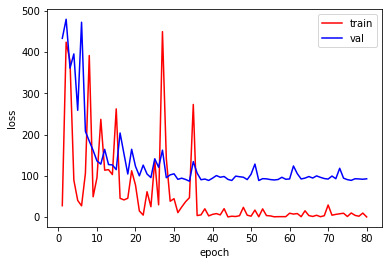

In [10]:
# Plot Graphs

for i in range(k):
  plt.plot(np.array(range(1, (num_epochs) + 1)), loss_train_log[i], c='r', label='train')
  plt.plot(np.array(range(1, (num_epochs) + 1)), loss_val_log[i], c='b', label='val')
  plt.legend(loc='upper right')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.savefig(f'training_learning_rate_0001_{i}.pdf')
  plt.show()


In [11]:
# Stage 2 (Re-training stage)

# Load patient metadata
meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_regression_train.csv')
# Get subject ids
ids_reg_train = list(meta_data_reg_train['subject_id'])
# Get subject ages
age_reg_train = list(meta_data_reg_train['age'])
# Get brain scan images
files_reg_img_train = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_reg_train]
files_reg_msk_train = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_reg_train]

# Feed into DatasetClass and dataloader
dataset = ImageRegressionDataset(files_reg_img_train, files_reg_msk_train, age_reg_train, img_spacing, img_size)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

Loading Data: 100%|██████████| 500/500 [01:04<00:00,  7.73it/s]


In [12]:
# Re-load the 47 samples from segmentation for validation set

meta_data_seg_val = pd.read_csv(data_dir + 'meta/meta_data_segmentation_train.csv')
ids_seg_val = list(meta_data_seg_val['subject_id'])
age_seg_val = list(meta_data_seg_val['age'])
files_seg_img_val = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_val]
files_seg_msk_val = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_val]

# LOAD TRAINING DATA
dataset_val = ImageRegressionDataset(files_seg_img_val, files_seg_msk_val, age_seg_val, img_spacing, img_size)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

Loading Data: 100%|██████████| 47/47 [00:05<00:00,  7.91it/s]


In [13]:
# Define model and variables for logging

model_regression_cnn = Age_Prediction_CNN().to(device)
model_regression_cnn.train()

optimizer = torch.optim.Adam(model_regression_cnn.parameters(), lr=learning_rate)

loss_train_log = np.empty((0, num_epochs))
loss_val_log = np.empty((0, num_epochs))
mae_retrain = 0

In [14]:
print('START RE-TRAINING...')


# Loop through number of epochs
for j in range(num_epochs):

  # Loop through each batches of training samples
  for data_idx, data_sample in enumerate(dataloader):
    img, age = data_sample['img'].to(device), data_sample['age'].to(device).to(torch.float)
    optimizer.zero_grad()
    prd = model_regression_cnn(img)
    loss = F.mse_loss(prd, age.unsqueeze(1)).cpu()
    loss.backward()
    optimizer.step()
  
  # Calculate loss for the epoch
  loss_train_log = np.append(loss_train_log, loss.detach().numpy())

  print('+ TRAINING \tEpoch: {} \tLoss: {:.6f}'.format(j, loss.item()))
  
  # Loop through each batches of validation samples
  loss_val = 0
  sum_pts = 0
  with torch.no_grad():
    for data_idx, data_sample in enumerate(dataloader_val):
      img, age = data_sample['img'].to(device), data_sample['age'].to(device).to(torch.float)

      prd = model_regression_cnn(img)
      loss_val += F.mse_loss(prd, age.unsqueeze(1)).cpu()
      mae_retrain += F.l1_loss(prd, age.unsqueeze(1)).cpu()
      sum_pts += 1
      
      
    if (j == 0 or j % 10 == 0):
      print('--------------------------------------------------')
      print(f'+ VALIDATE \tEpoch: {j} \tLoss: {loss_val/sum_pts}')
      print('--------------------------------------------------')
  
  loss_val /= sum_pts
  mae_retrain /= sum_pts

  loss_val_log = np.append(loss_val_log, loss_val.detach().numpy())

print('\nFinished TRAINING.')
print(f"MAE Retrain: {mae_retrain}")

START RE-TRAINING...
+ TRAINING 	Epoch: 0 	Loss: 53.144245
--------------------------------------------------
+ VALIDATE 	Epoch: 0 	Loss: 293.38983154296875
--------------------------------------------------
+ TRAINING 	Epoch: 1 	Loss: 283.695984
+ TRAINING 	Epoch: 2 	Loss: 517.677490
+ TRAINING 	Epoch: 3 	Loss: 294.842743
+ TRAINING 	Epoch: 4 	Loss: 24.019562
+ TRAINING 	Epoch: 5 	Loss: 346.813354
+ TRAINING 	Epoch: 6 	Loss: 79.558281
+ TRAINING 	Epoch: 7 	Loss: 41.945984
+ TRAINING 	Epoch: 8 	Loss: 144.801941
+ TRAINING 	Epoch: 9 	Loss: 25.066792
+ TRAINING 	Epoch: 10 	Loss: 36.794872
--------------------------------------------------
+ VALIDATE 	Epoch: 10 	Loss: 96.5230941772461
--------------------------------------------------
+ TRAINING 	Epoch: 11 	Loss: 18.353388
+ TRAINING 	Epoch: 12 	Loss: 35.041916
+ TRAINING 	Epoch: 13 	Loss: 123.124825
+ TRAINING 	Epoch: 14 	Loss: 29.573586
+ TRAINING 	Epoch: 15 	Loss: 176.129700
+ TRAINING 	Epoch: 16 	Loss: 178.866760
+ TRAINING 	Epoch: 17

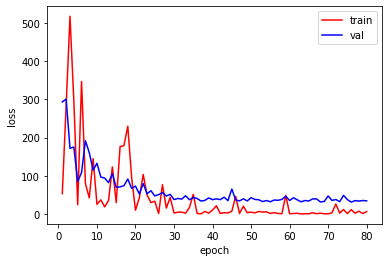

In [15]:
plt.plot(np.array(range(1, (num_epochs) + 1)), loss_train_log, c='r', label='train')
plt.plot(np.array(range(1, (num_epochs) + 1)), loss_val_log, c='b', label='val')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig('training_learning_rate_0001.pdf')
plt.show()

Load Test Data


In [16]:
! wget https://www.doc.ic.ac.uk/~bglocker/teaching/mli/brainage-test-data.zip
! unzip brainage-test-data.zip

--2023-03-02 16:51:15--  https://www.doc.ic.ac.uk/~bglocker/teaching/mli/brainage-test-data.zip
Resolving www.doc.ic.ac.uk (www.doc.ic.ac.uk)... 146.169.13.6
Connecting to www.doc.ic.ac.uk (www.doc.ic.ac.uk)|146.169.13.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1521 (1.5K) [application/zip]
Saving to: ‘brainage-test-data.zip’

brainage-test-data. 100%[===================>]   1.49K  --.-KB/s    in 0s      

2023-03-02 16:51:15 (370 MB/s) - ‘brainage-test-data.zip’ saved [1521/1521]

Archive:  brainage-test-data.zip
  inflating: data/brain_age/meta/meta_data_regression_test.csv  


Test Model on Test Data

In [17]:
# Load Test set

meta_data_seg_test = pd.read_csv(data_dir + 'meta/meta_data_regression_test.csv')
ids_seg_test = list(meta_data_seg_test['subject_id'])
age_seg_test = list(meta_data_seg_test['age'])
files_seg_img_test = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_test]
files_seg_msk_test = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_test]

# LOAD TRAINING DATA
dataset_test = ImageRegressionDataset(files_seg_img_test, files_seg_msk_test, age_seg_test, img_spacing, img_size)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

Loading Data: 100%|██████████| 100/100 [00:12<00:00,  7.80it/s]


START TESTING...

Finished TESTING.
MAE is 5.530886173248291
R2 is 0.8615747231164859


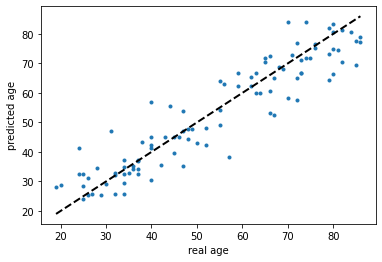

In [18]:
model_regression_cnn.eval()
print('START TESTING...')

mae_test = 0
r2_test = 0
idx = 0
real_age = []
pred_age = []
# Loop through each batches of test samples
with torch.no_grad():
  for data_idx, data_sample in enumerate(dataloader_test):
    img, age = data_sample['img'].to(device), data_sample['age'].to(device).to(torch.float)

    prd = model_regression_cnn(img)
    mae_test += F.l1_loss(prd, age.unsqueeze(1)).cpu()
    idx += 1
    real_age.append(age.cpu().numpy())
    pred_age.append(prd.squeeze(1).cpu().numpy())

mae_test /= idx
r2_test += r2_score(real_age, pred_age)

print('\nFinished TESTING.')
print(f"MAE is {mae_test}")
print(f"R2 is {r2_test}")

real_age = np.array(real_age)
pred_age = np.array(pred_age)
plt.figure()
plt.scatter(real_age, pred_age, marker=".")
plt.plot([real_age.min(), real_age.max()], [real_age.min(), real_age.max()], 'k--', lw=2)
plt.xlabel('real age')
plt.ylabel('predicted age')
plt.savefig('test_learning_rate_0001.pdf')
plt.show()


In [19]:
torch.save(model_regression_cnn.state_dict(), os.path.join(model_dir_regression_cnn, 'model_regression_cnn_lr_0001.pt'))